# 1. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split

# Modeling
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.metrics import *

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations

# 2. Read Data

In [2]:
panel = pd.read_csv(os.path.abspath("../input") + '/panel.csv')
survey = pd.read_csv(os.path.abspath("../input") + '/survey.csv')
response_train = pd.read_csv(os.path.abspath("../input") + '/response_train.csv')
response_test = pd.read_csv(os.path.abspath("../input") + '/response_test.csv')

__< 데이터 설명 >__  
  
* __panel__  
  
`GENDER` : 성별 - 1:남자 / 2:여자  
`REGION` : 지역  
`SQ1 ~ DQ7` : 설문조사 질문 설명  
  
* __Survey__  
  
`IR` : 난이도(응답가능성, 100이 최고) - 수치가 높으면 난이도가 높음  
`LOI` : 설문하는데 걸리는 시간 (분단위)  
`CPI` : 패널 응답 리워드 포인트 (1P~)  
  
* __Response_train__  
  
`ID` : submission을 식별하기 위한 ID로 사용

# 3. Data Cleansing

### panel

In [3]:
# panel 결측치 개수 확인
panel.isna().sum().sum()

218809

In [4]:
# BIRTH 대체할 결측치 확인
panel.BIRTH.value_counts().sort_values(ascending = False).index[0]

1982.0

In [5]:
# GENDER 대체할 결측치 확인
panel.GENDER.value_counts().sort_values(ascending = False).index[0]

2.0

In [6]:
# REGION 대체할 결측치 확인
panel.REGION.value_counts().sort_values(ascending = False).index[0]

2.0

In [7]:
# 결측치 처리
panel.BIRTH.fillna(panel.BIRTH.value_counts().sort_values(ascending = False).index[0],inplace = True)
panel.GENDER.fillna(panel.GENDER.value_counts().sort_values(ascending = False).index[0], inplace = True)
panel.REGION.fillna(panel.REGION.value_counts().sort_values(ascending = False).index[0],inplace = True)

## 나머지 데이터는 설문조사 결과이므로 0으로 처리
panel.fillna(0,inplace = True)

In [8]:
# 결측치 처리 후 확인
panel.isna().sum().sum()

0

### 질문 데이터 전처리

__< 처리 방법 >__  
  
* ',' , '.' 으로 이루어진 값을 `split`을 통해 응답값 통일화  
* 질문 선지에 없는 답이 명시되어 있는 경우 : __-1__  
* 멀티값인 경우 : __-2__

SQ1 - 성별

In [9]:
# `GENDER`열이 존재하기 때문에 삭제
panel = panel.drop(columns = ['SQ1'])

SQ2 - 출생년도

In [10]:
# error로 변환
panel.loc[panel['SQ2'] == 1 , 'SQ2'] = -1

# BIRTH와 SQ2의 답이 다른 경우 error로 변환
panel.loc[panel['SQ2'] != panel['BIRTH'] , 'SQ2'] = -1

# int 변환
panel['SQ2'] = panel['SQ2'].astype(int)

SQ3 - 사는 지역

In [11]:
panel['SQ3'] = panel['SQ3'].astype(str)
panel['SQ3'] = panel.SQ3.apply(lambda x : x.split('.')[0] if '.' in x else x).apply(lambda x : x.split(',')[0] if ',' in x else x)
panel['SQ3'] = panel['SQ3'].astype(int)

SQ4 - 사는 곳 유형

In [12]:
# SQ4 질문의 답
lst_SQ4 = list(np.arange(0,7,1).astype(str));lst_SQ4.append('97');lst_SQ4.append('-2')

In [13]:
panel['SQ4'] = panel['SQ4'].astype(str)
panel['SQ4'] = panel.SQ4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if len(x) < 3 else x).apply(lambda x : x if x in lst_SQ4 else -1)
panel['SQ4'] = panel['SQ4'].astype(int)

SQ5 - 최종학력

In [14]:
# SQ5 질문의 답
lst_SQ5 = list(np.arange(0,5,1).astype(str))

In [15]:
panel['SQ5'] = panel['SQ5'].astype(str)
panel['SQ5'] = panel.SQ5.apply(lambda x : x if x in lst_SQ5  else '-1')
panel['SQ5'] = panel['SQ5'].astype(int)

SQ6 - 결혼 유무

In [16]:
# SQ6 질문의 답
lst_SQ6 = list(np.arange(0,3,1).astype(str));lst_SQ6.append('97');lst_SQ6.append('-2')

In [17]:
panel['SQ6'] = panel['SQ6'].astype(str)
panel['SQ6'] = panel.SQ6.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if len(x) <= 5 else x).apply(lambda x : x if x in lst_SQ6 else -1)
panel['SQ6'] = panel['SQ6'].astype(int)

SQ7 - 자녀 나이

In [18]:
# SQ7 질문의 답
lst_SQ7 = list(np.arange(0,17,1).astype(str));lst_SQ7.append('99')

In [19]:
panel['SQ7'] = panel['SQ7'].astype(str)
panel['SQ7'] = panel.SQ7.apply(lambda x : x.split('.')[0] if x.split('.')[0] == '99' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_SQ7 else x).apply(lambda x : x if x in lst_SQ7 else -1)
panel['SQ7'] = panel['SQ7'].astype(int)

SQ8 - 가족 수

In [20]:
# SQ8 질문의 답
lst_SQ8 = list(np.arange(0,6,1).astype(str))

In [21]:
panel['SQ8'] = panel['SQ8'].astype(str)
panel['SQ8'] = panel.SQ8.apply(lambda x : x if x in lst_SQ8 else '-1')
panel['SQ8'] = panel['SQ8'].astype(int)

A1 - 최근 1년이내 구입한 가전제품 __(multi)__

In [22]:
# A1 질문의 답
lst_A1 = list(np.arange(0,23,1).astype(str));lst_A1.append('99');lst_A1.append('-2')

In [23]:
panel['A1'] = panel['A1'].astype(str)
panel['A1'] = panel.A1.apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_A1 and len(x) <= 3 else x).apply(lambda x : -2 if len(x) >=3 else x).apply(lambda x : x if x in lst_A1 else '-1')
panel['A1'] = panel['A1'].astype(int)

B1 - 휴대폰 인터넷 통신망  
  

In [24]:
panel.B1.value_counts()

0               3598
4               3134
1               2706
99              1720
8               1642
                ... 
97,모르겠다            1
1,10,2,3,4,6       1
1,6                1
10,4,7             1
10,3               1
Name: B1, Length: 119, dtype: int64

In [25]:
# B1에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['B1'])

B2 - 휴대폰 통신사  


In [26]:
panel.B2.value_counts()

0              3981
1              3869
3              1765
99             1360
2              1311
               ... 
97,모르겠다           1
97,알페온            1
97,저도 뚜벅이..       1
6,97              1
97,그랜져            1
Name: B2, Length: 109, dtype: int64

In [27]:
# B2에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['B2'])

B3 - 휴대폰 제조사  

In [28]:
# B3 질문의 답
lst_B3 = list(np.arange(0,8,1).astype(str));lst_B3.append('99');lst_B3.append('-2');lst_B3.append('97')

In [29]:
panel['B3'] = panel['B3'].astype(str)

# 9997 -> 현재 사용 중인 휴대폰 없음으로 처리
panel.loc[panel['B3'] == '9997', 'B3'] == '99'
panel['B3'] = panel.B3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : -1 if len(x) >=3 else x).apply(lambda x : x if x in lst_B3 else '-1')
panel['B3'] = panel['B3'].astype(int)

B4 - 사용하는 스마트 기기 __(multi)__

In [30]:
# B4 질문의 답
lst_B4 = list(np.arange(0,9,1).astype(str));lst_B4.append('99');lst_B4.append('-2');lst_B4.append('97')

In [31]:
panel['B4'] = panel['B4'].astype(str)
panel['B4'] =panel.B4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_B4 else '-1')
panel['B4'] = panel['B4'].astype(int)

B5 - TV 케이블 망

In [32]:
# B5 질문의 답
lst_B5 = list(np.arange(0,11,1).astype(str));lst_B5.append('99');lst_B5.append('-2');lst_B5.append('97')

In [33]:
panel['B5'] = panel['B5'].astype(str)
panel['B5'] =panel.B5.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_B5 and len(x) <= 3 else x).apply(lambda x : x if x in lst_B5 else '-1')
panel['B5'] = panel['B5'].astype(int)

C1 - 가입 보험 종류 __(multi)__

In [34]:
# C1 질문의 답
lst_C1 = list(np.arange(0,16,1).astype(str));lst_C1.append('99');lst_C1.append('-2')

In [35]:
panel['C1'] = panel['C1'].astype(str)
panel['C1'] =panel.C1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '99' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C1 and len(x) <= 3 else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_C1 else '-1')
panel['C1'] = panel['C1'].astype(int)

C2 - 주 거래 은행

In [36]:
# C2 질문의 답
lst_C2 = list(np.arange(0,15,1).astype(str));lst_C2.append('97')

In [37]:
panel['C2'] = panel['C2'].astype(str)
panel['C2'] =panel.C2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C2 and len(x) <= 3 else x).apply(lambda x : x if x in lst_C2 else '-1')
panel['C2'] = panel['C2'].astype(int)

C3 - 사용중인 간편결제서비스 __(multi)__

In [38]:
# C3 질문의 답
lst_C3 = list(np.arange(0,11,1).astype(str));lst_C3.append('97');lst_C3.append('99');lst_C3.append('-2')

In [39]:
panel['C3'] = panel['C3'].astype(str)
panel['C3'] =panel.C3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_C3 and len(x) <= 3 else x).apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_C3 else '-1')
panel['C3'] = panel['C3'].astype(int)

F1 - 주로 이용하는 대형할인마트

In [40]:
# F1 질문의 답
lst_F1 = list(np.arange(0,11,1).astype(str));lst_F1.append('97');lst_F1.append('99')

In [41]:
panel['F1'] = panel['F1'].astype(str)
panel['F1'] =panel.F1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_F1 and len(x) <= 3 else x).apply(lambda x : x if x in lst_F1 else '-1')
panel['F1'] = panel['F1'].astype(int)

F2 - 주로 이용하는 온라인 대형할인마트

In [42]:
# F2 질문의 답
lst_F2 = list(np.arange(0,6,1).astype(str));lst_F2.append('97');lst_F2.append('99')

In [43]:
panel['F2'] = panel['F2'].astype(str)
panel['F2'] =panel.F2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_F2 and len(x) <= 3 else x).apply(lambda x : x if x in lst_F2 else '-1')
panel['F2'] = panel['F2'].astype(int)

H1 - 3개월간 음용한 주류

In [44]:
# H1 질문의 답
lst_H1 = list(np.arange(0,12,1).astype(str));lst_H1.append('97');lst_H1.append('99')

In [45]:
panel['H1'] = panel['H1'].astype(str)
panel['H1'] =panel.H1.apply(lambda x : '-2' if len(x) >=3 else x).apply(lambda x : x if x in lst_H1 else '-1')
panel['H1'] = panel['H1'].astype(int)

T1 - 피우는 담배 브랜드

In [46]:
# T1 질문의 답
lst_T1 = list(np.arange(0,34,1).astype(str));lst_T1.append('971');lst_T1.append('972');lst_T1.append('99')

In [47]:
panel['T1'] = panel['T1'].astype(str)

# 9997 -> 담배 피우지 않음으로 처리
panel.loc[panel['T1'] == '9997', 'T1'] == '99'
panel['T1'] =panel.T1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '971' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] == '972' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_T1 else x).apply(lambda x : x if x in lst_T1 else '-1')
panel['T1'] = panel['T1'].astype(int)

X1 - 주로 운전하는 자동차의 제조사

In [48]:
# X1 질문의 답
lst_X1 = list(np.arange(0,26,1).astype(str));lst_X1.append('97');lst_X1.append('99')

In [49]:
panel['X1'] = panel['X1'].astype(str)
panel['X1'] =panel.X1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_X1 else x).apply(lambda x : x if x in lst_X1 else '-1')
panel['X1'] = panel['X1'].astype(int)

X2 - 자동차 구매 형태

In [50]:
panel.X2.value_counts()

0          8799
1.0        2186
99.0       1119
2.0         629
1           469
4.0         459
3.0         429
5.0         406
6.0         367
11.0        237
7.0         217
8.0         186
9.0         180
2           109
10.0         88
99           86
21.0         64
12.0         42
4            38
5            38
16.0         37
1.0          31
20.0         28
13.0         28
6            27
8            24
14.0         23
19.0         22
97.0         21
3            21
7            19
98.0         18
17.0         13
6.0          12
99.0         10
15.0          9
2.0           8
3.0           7
98            7
11            7
9             7
18.0          6
4.0           5
5.0           4
7.0           3
10            3
12            3
21.0          2
8.0           2
22.0          2
14            1
9.0           1
10.0          1
11.0          1
14.0          1
97,프리랜서       1
Name: X2, dtype: int64

In [51]:
# X2에 해당하는 답들이 아니라고 판단하여 삭제
panel = panel.drop(columns = ['X2'])

X3 - 자주 이용하는 주유소

In [52]:
# X3 질문의 답
lst_X3 = list(np.arange(0,9,1).astype(str));lst_X3.append('97');lst_X3.append('99')

In [53]:
panel['X3'] = panel['X3'].astype(str)
panel['X3'] =panel.X3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_X3 else x).apply(lambda x : x if x in lst_X3 else '-1')
panel['X3'] = panel['X3'].astype(int)

X4 - 주 자동차 연료 타입

In [54]:
# X4 질문의 답
lst_X4 = list(np.arange(0,5,1).astype(str));lst_X4.append('97');lst_X4.append('99')

In [55]:
panel['X4'] = panel['X4'].astype(str)
panel['X4'] =panel.X4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_X4 else x).apply(lambda x : x if x in lst_X4 else '-1')
panel['X4'] = panel['X4'].astype(int)

DQ1 - 직업

In [56]:
# DQ1 질문의 답
lst_DQ1 = list(np.arange(0,16,1).astype(str));lst_DQ1.append('97');lst_DQ1.append('99')

In [57]:
panel['DQ1'] = panel['DQ1'].astype(str)
panel['DQ1'] =panel.DQ1.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ1 else x).apply(lambda x : x if x in lst_DQ1 else '-1')
panel['DQ1'] = panel['DQ1'].astype(int)

DQ2 - 근무하는 직종

In [58]:
# DQ2 질문의 답
lst_DQ2 = list(np.arange(0,23,1).astype(str));lst_DQ2.append('97');lst_DQ2.append('99')

In [59]:
panel['DQ2'] = panel['DQ2'].astype(str)
panel['DQ2'] =panel.DQ2.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ2 else x).apply(lambda x : x if x in lst_DQ2 else '-1')
panel['DQ2'] = panel['DQ2'].astype(int)

DQ3 - 회사에서 담당하고 있는 직무분야

In [60]:
# DQ3 질문의 답
lst_DQ3 = list(np.arange(0,22,1).astype(str));lst_DQ3.append('97');lst_DQ3.append('99')

In [61]:
panel['DQ3'] = panel['DQ3'].astype(str)
panel['DQ3'] =panel.DQ3.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split('.')[0] if x.split('.')[0] in lst_DQ3 else x).apply(lambda x : x if x in lst_DQ3 else '-1')
panel['DQ3'] = panel['DQ3'].astype(int)

DQ4 - 직장에서 직급

In [62]:
# DQ4 질문의 답
lst_DQ4 = list(np.arange(0,8,1).astype(str));lst_DQ4.append('97');lst_DQ4.append('99')

In [63]:
panel['DQ4'] = panel['DQ4'].astype(str)
panel['DQ4'] =panel.DQ4.apply(lambda x : x.split(',')[0] if x.split(',')[0] == '97' else x).apply(lambda x : x.split(',')[0] if x.split(',')[0] in lst_DQ4 else x).apply(lambda x : x if x in lst_DQ4 else '-1')
panel['DQ4'] = panel['DQ4'].astype(int)

DQ5 - 회사의 규모

In [64]:
panel['DQ5'] = panel['DQ5'].astype(int)

DQ6 - 한달 평균 가구소득

In [65]:
panel['DQ6'] = panel['DQ6'].astype(int)

DQ7 - 고용 형태

In [66]:
panel['DQ7'] = panel['DQ7'].astype(int)

### survey

In [67]:
survey.isna().sum()

surveyID         0
TITLE            0
IR               0
LOI              0
CATEGORIES    5027
CPI              0
dtype: int64

In [68]:
# CATEGORIES 열은 의미가 없다고 판단되어 삭제
survey.drop(columns  = 'CATEGORIES',inplace = True)

In [69]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976 entries, 0 to 5975
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   surveyID  5976 non-null   object 
 1   TITLE     5976 non-null   object 
 2   IR        5976 non-null   int64  
 3   LOI       5976 non-null   int64  
 4   CPI       5976 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 233.6+ KB


### response_train

In [70]:
response_train.isna().sum()

userID      0
surveyID    0
TIME        0
STATUS      0
dtype: int64

### response_test

In [71]:
response_test.isna().sum()

ID          0
userID      0
surveyID    0
TIME        0
dtype: int64

### Merge Data

In [72]:
# 결측값 확인
for i in panel.columns:
    try:
        print( i,'//' ,np.sum(panel[i] == 0) / panel.shape[0])
    except:
        pass

userID // 0.0
BIRTH // 0.0
GENDER // 0.0
REGION // 0.0
TYPE // 0.0
SQ2 // 0.0
SQ3 // 0.09690273501177323
SQ4 // 0.0973253637626034
SQ5 // 0.15190484815552738
SQ6 // 0.15220672583469178
SQ7 // 0.1849906417919459
SQ8 // 0.18728491215359536
A1 // 0.20956348487592827
B3 // 0.24403791583650306
B4 // 0.25381875264142967
B5 // 0.26323733623135903
C1 // 0.3160659300851295
C2 // 0.41484030670772204
C3 // 0.4265531606593009
F1 // 0.4703857996739721
F2 // 0.4793213789772384
H1 // 0.4933285032904667
T1 // 0.49846042383626155
X1 // 0.5119845438628268
X3 // 0.5558775584133309
X4 // 0.6999335869105838
DQ1 // 0.7594034897059712
DQ2 // 0.7828895731449617
DQ3 // 0.7886856245849182
DQ4 // 0.790315764052406
DQ5 // 0.7946628026323733
DQ6 // 0.7953873090623679
DQ7 // 0.798406085854012


In [73]:
train = response_train.merge(survey).merge(panel, on = 'userID')
test = response_test.merge(survey).merge(panel, on = 'userID')

In [74]:
gc.collect()

40

# 4. Features Engineering

* 질문관련

In [75]:
train['error_sum'] = (train.loc[:,'SQ2':'DQ7']==0).sum(axis=1)
test['error_sum'] = (test.loc[:,'SQ2':'DQ7']==0).sum(axis=1)

* 분할

In [76]:
train.columns

Index(['userID', 'surveyID', 'TIME', 'STATUS', 'TITLE', 'IR', 'LOI', 'CPI',
       'BIRTH', 'GENDER', 'REGION', 'TYPE', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6',
       'SQ7', 'SQ8', 'A1', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7', 'error_sum'],
      dtype='object')

In [77]:
train = train.drop([ 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7'],axis=1)

test = test.drop([ 'C2', 'C3', 'F1', 'F2',
       'H1', 'T1', 'X1', 'X3', 'X4', 'DQ1', 'DQ2', 'DQ3', 'DQ4', 'DQ5', 'DQ6',
       'DQ7'],axis=1)

In [78]:

len(set(train.userID.unique())-set((test.userID.unique())))

891

In [79]:
# train 데이터 분할
before_train = train.query("TIME>='2020-11-01 00:00:00' and TIME< '2021-03-01 00:00:00'")
train = train.query("TIME>='2021-03-01 00:00:00'")

In [80]:
len(set(test.userID.unique()) - set(train.userID.unique()))

182

* 최초 응답

In [81]:
a = train.sort_values(by='TIME').drop_duplicates(['userID'],keep='first')

In [82]:
first_survey = a.query('STATUS == 1')

In [83]:
first_survey['first_survey'] = 1

In [84]:
train = train.merge(first_survey[['userID','first_survey']], how='left')

In [85]:
train.fillna(0,inplace=True)

In [86]:
train.first_survey = train.first_survey.astype(object)

In [87]:
test = test.merge(first_survey[['userID','first_survey']], on='userID',how = 'left').fillna(0)

In [88]:
# 패널 아이디별, CPI 획득량 
Points_earned = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

train = train.merge(Points_earned, how='left')
train['Points_earned'].fillna(train['Points_earned'].mean(), inplace = True)
test = test.merge(Points_earned, how='left')
test['Points_earned'].fillna(test['Points_earned'].mean(), inplace = True)

In [89]:
# 패널 아이디별, LOI 실제 sum
LOI_SUM = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['LOI'].agg([('LOI_SUM',np.sum)])).reset_index()

train = train.merge(LOI_SUM, how='left')
train['LOI_SUM'].fillna(train['LOI_SUM'].mean(), inplace = True)
test = test.merge(LOI_SUM, how='left')
test['LOI_SUM'].fillna(test['LOI_SUM'].mean(), inplace = True)

In [90]:
# 패널 아이디별, IR 실제 sum
IR_SUM = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['IR'].agg([('IR_SUM',np.sum)])).reset_index()

train = train.merge(IR_SUM, how='left')
train['IR_SUM'].fillna(train['IR_SUM'].mean(), inplace = True)
test = test.merge(IR_SUM, how='left')
test['IR_SUM'].fillna(test['IR_SUM'].mean(), inplace = True)

In [91]:
"""#IR_index = (before_train.query('STATUS == 1')['IR'].value_counts()/before_train.query('STATUS == 1')['IR'].value_counts().sum()).head(2).index.tolist()
a = (before_train.query('STATUS == 1')['IR'].value_counts()/before_train.query('STATUS == 1')['IR'].value_counts().sum()).reset_index()
a = a.rename(columns = {'IR':'STAT1IR'})
a = a.rename(columns = {'index' : 'IR'})
train = train.merge(a,on = 'IR',how='left')
test = test.merge(a,on = 'IR',how='left')
train['STAT1IR'].fillna(train['STAT1IR'].mean(), inplace = True)
test['STAT1IR'].fillna(test['STAT1IR'].mean(), inplace = True)
# STATUS 가 1일 때 IR이 특정 구간일 확률"""

"#IR_index = (before_train.query('STATUS == 1')['IR'].value_counts()/before_train.query('STATUS == 1')['IR'].value_counts().sum()).head(2).index.tolist()\na = (before_train.query('STATUS == 1')['IR'].value_counts()/before_train.query('STATUS == 1')['IR'].value_counts().sum()).reset_index()\na = a.rename(columns = {'IR':'STAT1IR'})\na = a.rename(columns = {'index' : 'IR'})\ntrain = train.merge(a,on = 'IR',how='left')\ntest = test.merge(a,on = 'IR',how='left')\ntrain['STAT1IR'].fillna(train['STAT1IR'].mean(), inplace = True)\ntest['STAT1IR'].fillna(test['STAT1IR'].mean(), inplace = True)\n# STATUS 가 1일 때 IR이 특정 구간일 확률"

In [92]:
"""#LOI_index = (before_train.query('STATUS == 1')['LOI'].value_counts()/before_train.query('STATUS == 1')['LOI'].value_counts().sum()).head(2).index.tolist()
a = (before_train.query('STATUS == 1')['LOI'].value_counts()/before_train.query('STATUS == 1')['LOI'].value_counts().sum()).reset_index()
a = a.rename(columns = {'LOI':'STAT1LOI'})
a = a.rename(columns = {'index' : 'LOI'})
train = train.merge(a,on = 'LOI',how = 'left')
test = test.merge(a,on = 'LOI',how = 'left')
train['STAT1LOI'].fillna(train['STAT1LOI'].mean(), inplace = True)
test['STAT1LOI'].fillna(test['STAT1LOI'].mean(), inplace = True)
train.shape,test.shape
# STATUS 가 1일 때 IR이 특정 구간일 확률"""

"#LOI_index = (before_train.query('STATUS == 1')['LOI'].value_counts()/before_train.query('STATUS == 1')['LOI'].value_counts().sum()).head(2).index.tolist()\na = (before_train.query('STATUS == 1')['LOI'].value_counts()/before_train.query('STATUS == 1')['LOI'].value_counts().sum()).reset_index()\na = a.rename(columns = {'LOI':'STAT1LOI'})\na = a.rename(columns = {'index' : 'LOI'})\ntrain = train.merge(a,on = 'LOI',how = 'left')\ntest = test.merge(a,on = 'LOI',how = 'left')\ntrain['STAT1LOI'].fillna(train['STAT1LOI'].mean(), inplace = True)\ntest['STAT1LOI'].fillna(test['STAT1LOI'].mean(), inplace = True)\ntrain.shape,test.shape\n# STATUS 가 1일 때 IR이 특정 구간일 확률"

In [93]:
"""#CPI_index = (before_train.query('STATUS == 1')['CPI'].value_counts()/before_train.query('STATUS == 1')['CPI'].value_counts().sum()).head(2).index.tolist()
a = (before_train.query('STATUS == 1')['CPI'].value_counts()/before_train.query('STATUS == 1')['CPI'].value_counts().sum()).reset_index()
a = a.rename(columns = {'CPI':'STAT1CPI'})
a = a.rename(columns = {'index' : 'CPI'})
train = train.merge(a,on = 'CPI',how='left')
test = test.merge(a,on = 'CPI',how='left')
train['STAT1CPI'].fillna(train['STAT1CPI'].mean(), inplace = True)
test['STAT1CPI'].fillna(test['STAT1CPI'].mean(), inplace = True)
# STATUS 가 1일 때 IR이 특정 구간일 확률"""

"#CPI_index = (before_train.query('STATUS == 1')['CPI'].value_counts()/before_train.query('STATUS == 1')['CPI'].value_counts().sum()).head(2).index.tolist()\na = (before_train.query('STATUS == 1')['CPI'].value_counts()/before_train.query('STATUS == 1')['CPI'].value_counts().sum()).reset_index()\na = a.rename(columns = {'CPI':'STAT1CPI'})\na = a.rename(columns = {'index' : 'CPI'})\ntrain = train.merge(a,on = 'CPI',how='left')\ntest = test.merge(a,on = 'CPI',how='left')\ntrain['STAT1CPI'].fillna(train['STAT1CPI'].mean(), inplace = True)\ntest['STAT1CPI'].fillna(test['STAT1CPI'].mean(), inplace = True)\n# STATUS 가 1일 때 IR이 특정 구간일 확률"

* IR별 응답비율





In [94]:
train_IR = ((train.groupby('IR')['STATUS'].sum())/(train.IR.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_IR'})

In [95]:
train = train.merge(train_IR,on='IR')
test = test.merge(train_IR,on='IR', how = 'left').fillna(train_IR.mean()[1])

* LOI구간 별 응답비율

In [96]:
train_LOI = ((train.groupby('LOI')['STATUS'].sum())/(train.LOI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_LOI'})

In [97]:
train = train.merge(train_LOI,on='LOI')
test = test.merge(train_LOI, how = 'left').fillna(train_LOI.mean()[1])

* CPI구간 별 응답비율

In [98]:
train_CPI = ((train.groupby('CPI')['STATUS'].sum())/(train.CPI.value_counts().sort_index())).reset_index().rename(columns = {0 : 'STATUS_ratio_CPI'})

In [99]:
train = train.merge(train_CPI,on='CPI')
test = test.merge(train_CPI, how = 'left').fillna(train_CPI.mean()[1])

In [100]:
train.shape, test.shape

((1170545, 32), (1355517, 32))

* 시계열 피쳐 생성

In [101]:
# month는 drop 예정
train['TIME'] =  pd.to_datetime(train['TIME'], format='%Y/%m/%d')
train['weekday'] = train['TIME'].dt.dayofweek
train['month'] = train['TIME'].dt.month
train['hour'] = train['TIME'].dt.hour

test['TIME'] =  pd.to_datetime(test['TIME'], format='%Y/%m/%d')
test['weekday'] = test['TIME'].dt.dayofweek
test['month'] = train['TIME'].dt.month
test['hour'] = test['TIME'].dt.hour

In [102]:
a = (train['TIME'].max()-train.groupby('userID')['TIME'].min()).dt.days.reset_index()
a = a.rename(columns = {'TIME': 'last_survey'})
train['last_survey'] = train.merge(a, on = 'userID',how = 'left')['last_survey']
test['last_survey'] = test.merge(a,on = 'userID',how='left')['last_survey']

In [103]:
train['last_survey'].fillna(0,inplace = True)
test['last_survey'].fillna(0,inplace = True)

In [104]:
a = (train.groupby('userID')['TIME'].max()-train.groupby('userID')['TIME'].min()).dt.days
a = a/train.groupby('userID')['userID'].count()
a = a.reset_index()
a = a.rename(columns = {0:'TIMEFREQ'})
train['TIMEFREQ'] = train.merge(a,on = 'userID',how = 'left')['TIMEFREQ']
test['TIMEFREQ'] = test.merge(a,on = 'userID',how = 'left')['TIMEFREQ']
train['TIMEFREQ'].fillna(0,inplace = True)
test['TIMEFREQ'].fillna(0,inplace = True)

In [105]:
#train = train.merge(train.pivot_table(index = 'userID', columns = 'weekday',values = 'STATUS',aggfunc = np.mean).fillna(0),on='userID',how='left')
#test = test.merge(train.pivot_table(index = 'userID', columns = 'weekday',values = 'STATUS',aggfunc = np.mean).fillna(0),on='userID',how='left')

In [106]:
# 6~10월 요일 별 응답률
train_weekday_ratio = train.groupby('weekday')['STATUS'].mean().reset_index().rename(columns = {'STATUS' : 'STATUS_ratio_weekday'})

train = train.merge(train_weekday_ratio,on='weekday')
test = test.merge(train_weekday_ratio,on='weekday')
#tr_test = tr_test.merge(train_weekday_ratio,on='weekday')

In [107]:
# 6~10월 시간 별 응답률
train_hour_ratio = train.groupby('hour')['STATUS'].mean().reset_index().rename(columns = {'STATUS' : 'STATUS_ratio_hour'})

train = train.merge(train_hour_ratio,on='hour')
test = test.merge(train_hour_ratio,on='hour')
#tr_test = tr_test.merge(train_hour_ratio,on='hour')

In [108]:
train.shape, test.shape 

((1170545, 39), (1355517, 39))

* userID 별 응답률

In [109]:
"""userID_STATUS_ratio = before_train.STATUS.groupby(train.userID).sum() / before_train.STATUS.groupby(train.userID).count()
userID_STATUS_ratio.name = 'before_userID_STATUS_ratio'

train = train.merge(userID_STATUS_ratio,on='userID', how = 'left').fillna(userID_STATUS_ratio.mean())
test = test.merge(userID_STATUS_ratio,on='userID',how = 'left').fillna(userID_STATUS_ratio.mean())
tr_test = tr_test.merge(userID_STATUS_ratio,on='userID',how = 'left').fillna(userID_STATUS_ratio.mean())"""

"userID_STATUS_ratio = before_train.STATUS.groupby(train.userID).sum() / before_train.STATUS.groupby(train.userID).count()\nuserID_STATUS_ratio.name = 'before_userID_STATUS_ratio'\n\ntrain = train.merge(userID_STATUS_ratio,on='userID', how = 'left').fillna(userID_STATUS_ratio.mean())\ntest = test.merge(userID_STATUS_ratio,on='userID',how = 'left').fillna(userID_STATUS_ratio.mean())\ntr_test = tr_test.merge(userID_STATUS_ratio,on='userID',how = 'left').fillna(userID_STATUS_ratio.mean())"

In [110]:
train.shape, test.shape

((1170545, 39), (1355517, 39))

In [111]:
f_tr = train.groupby('userID')['IR'].agg([('user_IR_sum', np.sum),
                                   ('user_IR_mean', lambda x : np.round(np.mean(x))),
                                   ('user_IR_max', np.max), 
                                   ('user_IR_min', np.min),
                                   ('user_IR_std', lambda x : np.round(np.std(x)))]).reset_index()
train = train.merge(f_tr[['userID','user_IR_mean']], on = 'userID')

f_te = test.groupby('userID')['IR'].agg([('user_IR_sum', np.sum),
                                   ('user_IR_mean', lambda x : np.round(np.mean(x))),
                                   ('user_IR_max', np.max), 
                                   ('user_IR_min', np.min),
                                   ('user_IR_std', lambda x : np.round(np.std(x)))]).reset_index()
test = test.merge(f_te[['userID','user_IR_mean']], on = 'userID')
test['user_IR_mean'].fillna(train['user_IR_mean'].mean())
##################################################################################################

f_tr = train.groupby('userID')['LOI'].agg([('user_LOI_sum', np.sum),
                                   ('user_LOI_mean', lambda x : np.round(np.mean(x))),
                                   ('user_LOI_max', np.max), 
                                   ('user_LOI_min', np.min),
                                   ('user_LOI_std', lambda x : np.round(np.std(x)))]).reset_index()
train = train.merge(f_tr[['userID','user_LOI_mean']], on = 'userID')

f_te = test.groupby('userID')['LOI'].agg([('user_LOI_sum', np.sum),
                                   ('user_LOI_mean', lambda x : np.round(np.mean(x))),
                                   ('user_LOI_max', np.max), 
                                   ('user_LOI_min', np.min),
                                   ('user_LOI_std', lambda x : np.round(np.std(x)))]).reset_index()
test = test.merge(f_te[['userID','user_LOI_mean']], on = 'userID')
test['user_LOI_mean'].fillna(train['user_LOI_mean'].mean())
##################################################################################################

f_tr = train.groupby('userID')['CPI'].agg([('user_CPI_sum', np.sum),
                                   ('user_CPI_mean', lambda x : np.round(np.mean(x))),
                                   ('user_CPI_max', np.max), 
                                   ('user_CPI_min', np.min),
                                   ('user_CPI_std', lambda x : np.round(np.std(x)))]).reset_index()
train = train.merge(f_tr[['userID','user_CPI_mean']], on = 'userID')

f_te = test.groupby('userID')['CPI'].agg([('user_CPI_sum', np.sum),
                                   ('user_CPI_mean', lambda x : np.round(np.mean(x))),
                                   ('user_CPI_max', np.max), 
                                   ('user_CPI_min', np.min),
                                   ('user_CPI_std', lambda x : np.round(np.std(x)))]).reset_index()
test = test.merge(f_te[['userID','user_CPI_mean']], on = 'userID')
test['user_CPI_mean'].fillna(train['user_CPI_mean'].mean())

0          630.0
1          630.0
2          630.0
3          630.0
4          630.0
           ...  
1355512    825.0
1355513    825.0
1355514    825.0
1355515    825.0
1355516    825.0
Name: user_CPI_mean, Length: 1355517, dtype: float64

* BIRTH 이산화

In [112]:
train.loc[train.BIRTH < 1950,'BIRTH'] = 1940
train.loc[(1950 <=train.BIRTH) & (train.BIRTH < 1960),'BIRTH'] = 1950
train.loc[(1960 <= train.BIRTH) & (train.BIRTH < 1970),'BIRTH'] = 1960
train.loc[(1970 <=train.BIRTH) & (train.BIRTH < 1980),'BIRTH'] = 1970
train.loc[(1980 <=train.BIRTH) & (train.BIRTH < 1990),'BIRTH'] = 1980
train.loc[(1990 <=train.BIRTH) & (train.BIRTH < 2000),'BIRTH'] = 1990
train.loc[(2000 <=train.BIRTH) & (train.BIRTH < 2010),'BIRTH'] = 2000

# 나름대로 유의미?
train['BIRTH'] = train['BIRTH']

test.loc[test.BIRTH < 1950,'BIRTH'] = 1940
test.loc[(1950 <=test.BIRTH) & (test.BIRTH < 1960),'BIRTH'] = 1950
test.loc[(1960 <= test.BIRTH) & (test.BIRTH < 1970),'BIRTH'] = 1960
test.loc[(1970 <=test.BIRTH) & (test.BIRTH < 1980),'BIRTH'] = 1970
test.loc[(1980 <=test.BIRTH) & (test.BIRTH < 1990),'BIRTH'] = 1980
test.loc[(1990 <=test.BIRTH) & (test.BIRTH < 2000),'BIRTH'] = 1990
test.loc[(2000 <=test.BIRTH) & (test.BIRTH < 2010),'BIRTH'] = 2000

test['BIRTH'] = test['BIRTH']

In [113]:
a = train.groupby('BIRTH')['STATUS'].mean().reset_index()
a = a.rename(columns = {'STATUS' : 'BIRTH_STATUS'})
train['BIRTH_STATUS'] = train.merge(a,on = 'BIRTH')['BIRTH_STATUS']
test['BIRTH_STATUS'] = test.merge(a,on = 'BIRTH')['BIRTH_STATUS']
#tr_test['BIRTH_STATUS'] = tr_test.merge(a,on = 'BIRTH')['BIRTH_STATUS']

In [114]:
train.shape, test.shape

((1170545, 43), (1355517, 43))

* 응답 추세(2020/6~10)

In [115]:
week_to = train['TIME'].max()
week_trans = []
for i in range(6):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(train.query('@week_from < TIME <= @week_to')
                      .groupby('userID')['STATUS']
                      .agg([(f'w{6-i}', 'mean')])
                      .reset_index())
    week_to = week_from
    #userID별 월별 응답 평균

In [116]:
# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'userID': train.userID.unique()})

In [117]:
for w in week_trans[::-1]:
    f = f.merge(w,how='left',on='userID')

In [118]:
for i in f.columns[1:]:
    f = f.fillna(f[i].mean())

In [119]:
train = train.merge(f, how='left')
test = test.merge(f, how='left')
#tr_test = tr_test.merge(f, how ='left')

In [120]:
train.shape, test.shape

((1170545, 49), (1355517, 49))

In [121]:
a = (before_train.groupby('userID')['STATUS'].sum())/(before_train.groupby('userID')['userID'].count())
a.name = 'user'
a = a.reset_index()
train = train.merge( a , on ='userID',how='left')
test = test.merge(a, on = 'userID',how='left')
#tr_test = tr_test.merge(a, on ='userID',how = 'left')
train['user'].fillna(0,inplace = True)
test['user'].fillna(0,inplace = True)
#tr_test['user'].fillna(tr_test['user'].mean(),inplace = True)
train.shape,test.shape

((1170545, 50), (1355517, 50))

In [122]:
a = before_train.groupby('userID')['userID'].count()
a.name = 'user_count'
a = a.reset_index()
before_train = before_train.merge(a, on = 'userID',how ='left')
train = train.merge(a, on = 'userID', how = 'left')
test = test.merge(a,on = 'userID', how ='left')
#tr_test = tr_test.merge(a,on = 'userID', how ='left')
train['user_count'].fillna(0,inplace = True)
test['user_count'].fillna(0,inplace = True)
#tr_test['user_count'].fillna(tr_test['user_count'].mean(),inplace = True)

In [123]:
a = (before_train.query('STATUS == 1')['user_count'].value_counts()/before_train.query('STATUS == 1')['user_count'].value_counts().sum()).reset_index()
a = a.rename(columns = {'user_count' : 'STAT1user_count'})
a = a.rename(columns = {'index' : 'user_count'})
before_train = before_train.merge(a,on = 'user_count')
train = train.merge(a,on = 'user_count',how ='left')
test = test.merge(a,on = 'user_count', how ='left')
#tr_test = tr_test.merge(a,on = 'user_count', how ='left')
train['STAT1user_count'].fillna(0,inplace = True)
test['STAT1user_count'].fillna(0,inplace = True)


In [124]:
IR_index = (before_train.query('STATUS == 1')['IR'].value_counts()/before_train.query('STATUS == 1')['IR'].value_counts().sum()).sort_values(ascending = False).head(2).index.tolist()
LOI_index = (before_train.query('STATUS == 1')['LOI'].value_counts()/before_train.query('STATUS == 1')['LOI'].value_counts().sum()).sort_values(ascending = False).head(5).index.tolist()
CPI_index = (before_train.query('STATUS == 1')['CPI'].value_counts()/before_train.query('STATUS == 1')['CPI'].value_counts().sum()).sort_values(ascending = False).head(5).index.tolist()

In [125]:
train['IR_ind'] = train['IR'].apply(lambda x : 1if x in IR_index else 0)
train['LOI_ind'] = train['LOI'].apply(lambda x : 1 if x in LOI_index else 0)
train['CPI_ind'] = train['CPI'].apply(lambda x : 1 if x in CPI_index else 0)
test['IR_ind'] = test['IR'].apply(lambda x : 1 if x in IR_index else 0)
test['LOI_ind'] = test['LOI'].apply(lambda x : 1 if x in LOI_index else 0)
test['CPI_ind'] = test['CPI'].apply(lambda x : 1 if x in CPI_index else 0)
train.fillna(0,inplace = True)
test.fillna(0,inplace = True)

In [126]:
train_columns = ['SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6',
       'SQ7', 'SQ8', 'A1', 'B3', 'B4', 'B5', 'C1']

In [127]:
most_status_list = []
for i in train_columns:
  most_status_list.append(list(train.groupby(i)['STATUS'].mean().sort_values(ascending = False).head(1).index))

In [128]:
#for i in range(len(train_columns)):
 # train[train_columns[i]+str('best3')] = train[train_columns[i]].apply(lambda x : 1 if x in most_status_list[i] else 0)

In [129]:
#for i in range(len(train_columns)):
 # test[train_columns[i]+str('best3')] = test[train_columns[i]].apply(lambda x : 1 if x in most_status_list[i] else 0)

In [130]:
#a = train.groupby('userID')['STATUS'].sum()/train.groupby('userID')['userID'].count()
#a = a.reset_index()
#a = a.rename(columns = {0:'STATUS/userID'})

In [131]:
#train = train.merge(a,on = 'userID')

In [132]:
#test = test.merge(a, on = 'userID')

In [133]:
#error_rate = pd.Series()
#for i in train_columns:
#  error_rate[i] = train.loc[(train[i]==-1)].shape[0]/train.shape[0]
#nan_rate = pd.Series()
#for i in train_columns:
#  nan_rate[i] = train.loc[(train[i]==0)].shape[0]/train.shape[0]

In [134]:
"""error_rate = error_rate.reset_index().rename(columns = {0 : 'values'})
error_list = list(error_rate.sort_values(ascending = False,by = 'values').head(15)['index'].values)
nan_rate = nan_rate.reset_index().rename(columns = {0 : 'values'})
nan_list = list(nan_rate.sort_values(ascending = False,by = 'values').head(15)['index'].values)"""

"error_rate = error_rate.reset_index().rename(columns = {0 : 'values'})\nerror_list = list(error_rate.sort_values(ascending = False,by = 'values').head(15)['index'].values)\nnan_rate = nan_rate.reset_index().rename(columns = {0 : 'values'})\nnan_list = list(nan_rate.sort_values(ascending = False,by = 'values').head(15)['index'].values)"

In [135]:
#nan_error_list = list(set(error_list) | set(nan_list))

In [136]:
"""error = [-1,0]
for i in nan_error_list:
  a = train.groupby('userID')[i].min().apply(lambda x : 1 if x in error else 0).reset_index()
  a = a.rename(columns = {i:f'{i}nan_error_rate'})
  train = train.merge(a,on = 'userID')"""

"error = [-1,0]\nfor i in nan_error_list:\n  a = train.groupby('userID')[i].min().apply(lambda x : 1 if x in error else 0).reset_index()\n  a = a.rename(columns = {i:f'{i}nan_error_rate'})\n  train = train.merge(a,on = 'userID')"

In [137]:
"""for i in nan_error_list:
  a = test.groupby('userID')[i].min().apply(lambda x : 1 if x in error else 0).reset_index()
  a = a.rename(columns = {i:f'{i}nan_error_rate'})
  test = test.merge(a,on = 'userID')"""

"for i in nan_error_list:\n  a = test.groupby('userID')[i].min().apply(lambda x : 1 if x in error else 0).reset_index()\n  a = a.rename(columns = {i:f'{i}nan_error_rate'})\n  test = test.merge(a,on = 'userID')"

# 5. Feature Selection

* 학습용 데이터들 만들기

In [138]:
train = train.drop(columns = 'month')
test = test.drop(columns = 'month')

In [139]:
train['SQ6'] = train['SQ6'].apply(lambda x : -1 if x in [-2,-1,97] else x)
test['SQ6'] = test['SQ6'].apply(lambda x : -1 if x in [-2,-1,97] else x)

In [140]:
X_train = train.iloc[:,5:]
y_train = train.STATUS
X_test = test.iloc[:,5:]
ID = test['ID']

In [141]:
 #범주형 변수와 수치형 변수를 분리
cat_features = ['GENDER', 'REGION', 'TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B3', 'B4', 'B5', 'C1','weekday', 'hour','first_survey']
num_features = list(set(X_train.columns) - set(cat_features))

In [142]:
X_train['GENDER'] = X_train['GENDER'].astype(int)
X_train['REGION'] = X_train['REGION'].astype(int)
X_test['GENDER'] = X_test['GENDER'].astype(int)
X_test['REGION'] = X_test['REGION'].astype(int)
X_train['first_survey'] = X_train['first_survey'].astype(int)
X_test['first_survey'] = X_test['first_survey'].astype(int)

In [143]:
len(X_train.columns)

49

In [144]:
X_test.fillna(0,inplace = True)
X_train.shape,X_test.shape

((1170545, 49), (1355517, 49))

* 라벨 인코딩

In [145]:
from sklearn.preprocessing import LabelEncoder
               
for i in cat_features:
    X_train[i] = LabelEncoder().fit_transform(X_train[i])

for i in cat_features:
    X_test[i] = LabelEncoder().fit_transform(X_test[i])

### Shap

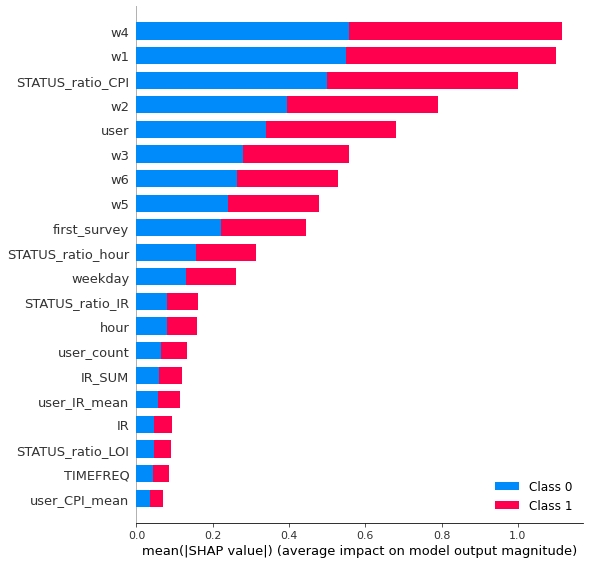

,column_name,shap_importance
40,w4,0.55742
37,w1,0.550411
26,STATUS_ratio_CPI,0.500782
38,w2,0.395011
43,user,0.340275
39,w3,0.27822
42,w6,0.264657
41,w5,0.239932
20,first_survey,0.221719
32,STATUS_ratio_hour,0.156656


In [147]:
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=42).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [148]:
features_selected = importance_df.query('shap_importance > 0').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
#X_valid = X_valid[features_selected]
X_train.shape, X_test.shape#, X_valid.shape

((1170545, 47), (1355517, 47))

In [149]:
X_train.shape, X_test.shape#, X_valid.shape

((1170545, 47), (1355517, 47))

In [150]:
len(set(test.userID.unique()) - set(before_train.userID.unique()))
# 비포 트레인에 없는 ID => 총 3천개
# 트레인에 없는 ID => 총 4백개
# tr_test에 없는 ID => 총 1700개

2569

# 6. Modeling

In [152]:
# Set Dataset
train_X, valid_X, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
evals = [(valid_X, valid_y)] 

In [153]:
gc.collect()

6564

* XGBoost

In [156]:
from xgboost import XGBClassifier

In [157]:
xgb = XGBClassifier(random_state = 42)

# RandomSearchCV를 이용한 XGBoost의 하이퍼 파라미터 튜닝
param_grid={'learning_rate': [1, 0.1, 0.01],
         'n_estimators': [100, 200, 300],
         'max_depth':[3,4,6,8,10],
         'subsamle':[0.3, 0.5, 0.7, 1],
         'min_child_weight':[10,20,50,100],
         'objective':['binary:logistic'],
         'eval_metric':['error'],
         'min_split_loss':[10,20,50,100],
         'colsample_bytree': [0.5, 0.7, 0.9, 1],
         'reg_alpha': [0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
         'reg_lambda': [0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
         'scale_pos_weight': np.arange(0.0, 50.1, 0.1),
         'boost_from_average' : [False]
}


xgb_rcv = RandomizedSearchCV(xgb, param_distributions=param_grid, scoring='roc_auc', n_jobs = -1, cv = 3, n_iter=8) 
xgb_rcv.fit(X_train,y_train)


print('최적 하이퍼 파라미터:\n', xgb_rcv.best_params_)
print('최고 예측 스코어: {0:.4f}'.format(xgb_rcv.best_score_))
print(-(xgb_rcv.score(valid_X, valid_y)))

[04:40:07] WARNING: ..\src\learner.cc:541: 
Parameters: { boost_from_average, subsamle } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:
 {'subsamle': 0.3, 'scale_pos_weight': 1.9000000000000001, 'reg_lambda': 4, 'reg_alpha': 0.0005, 'objective': 'binary:logistic', 'n_estimators': 100, 'min_split_loss': 20, 'min_child_weight': 50, 'max_depth': 6, 'learning_rate': 0.01, 'eval_metric': 'error', 'colsample_bytree': 0.5, 'boost_from_average': False}
최고 예측 스코어: 0.9248
-0.9299215380160137


In [159]:
xgb_pred = xgb_rcv.predict(valid_X)
xgb_pred_proba = xgb_rcv.predict_proba(valid_X)[:,1]

print(-(xgb_rcv.score(valid_X, valid_y)))

-0.9299215380160137


* 점수확인

In [151]:
from sklearn.metrics import *

def get_clf_eval(y_test, pred=None, pred_proba=None): 
    confusion = confusion_matrix(y_test, pred) 
    accuracy = accuracy_score(y_test, pred) 
    precision = precision_score(y_test, pred) 
    recall = recall_score(y_test, pred) 
    f1 = f1_score(y_test, pred) 
    roc_auc = roc_auc_score(y_test, pred_proba) 
    
    print('Confusion Matrix') 
    print(confusion) 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, roc_auc: {4:.4f}'.format( accuracy, precision, recall, f1, roc_auc))

In [160]:
get_clf_eval(valid_y, xgb_pred, xgb_pred_proba)

Confusion Matrix
[[182427  43282]
 [ 12328 113127]]
accuracy: 0.8416, precision: 0.7233, recall: 0.9017, f1: 0.8027, roc_auc: 0.9299


# 7. Submission

In [161]:
pd.DataFrame({'ID': ID, 'STATUS':  xgb_rcv.predict_proba(X_test)[:,1]}).to_csv('XGBoost_0.89734.csv', index=False)